# 5.3 사전 훈련된 컨브넷 사용하기

작은 이미지 데이터셋에 딥러닝을 적용하는 일반적이고 매우 효과적인 방법은 사전 훈련된 네트워크를 사용하는 것입니다. 사전 훈련된 네트워크(pretrained network)는 일반적으로 대규모 이미지 분류 문제를 위해 대량의 데이터셋에서 미리 훈련되어 저장된 네트워크입니다. 원본 데이터셋이 충분히 크고 일반적이라면 사전 훈련된 네트워크에 의해 가습된 특성의 계층 구조는 실제 세상에 대한 일반적인 모델로 효율적인 역할을 할 수 있습니다.

여기에서는 (1400만 개의 레이블된 이미지와 1000개의 클래스로 이루어진) ImageNet 데이터 셋에서 훈련된 대규모 컨브넷을 사용해 보겠습니다.

2014년에 개발한 VGG16 구조를 사용하겠습니다. VGG16은 조금 오래되었고 최고 수준의 성능에는 못 미치며 최근의 다른 모델보다는 조금 무겁습늬다.

사전 훈련된 네트워크를 사용하는 두 가지 방법이 있습니다. 특성 추출(feature extraction)과 미세 조정(fine tuning)입니다

### 5.3.1 특성 추출
특성 추출은 사전에 학습된 네트워크의 표현을 사용하여 새로운 샘플에서 흥미로운 특성을 뽑아내는 것입니다. 이런 특성을 사용하여 새로운 분류기를 처음부터 훈련합니다.

첫 번째 부분을 모델의 합성곱 기반 층(convolutional base)이라고 부르겠습니다. 컨브넷의 경우 특성 추출은 사전에 훈련된 네트워크의 합성곱 기반 층을 선택하여 새로운 데이터를 통과시키고, 그 출력으로 새로운 분류기를 훈련합니다.

왜 합성곱 층만 재사용할까요? 완전 연결 분류기도 재사용할 수 있을까요? 일반적으로 권장하지 않습니다. 합성곱 층에 의해 학습된 표현이 더 일반적이어서 재사용이 가능하기 때문입니다. 모델의 하위 층은 (에지, 색깔, 질감 등) 지역적이고 매우 일반적인 특성 맵을 추출합니다. 반면에 상위 층은 ('강아지 눈'이나 '고양이 귀'처럼) 좀 더 추상적인 개념을 추출합니다.

VGG16 모델은 케라스에 패키지로 포함되어 있습니다. keras.applications 모듈에서 사용 가능한 이미지 분류 모델은 다음과 같습니다.
- Xception
- Inception V3
- ResNet50
- VGG16
- VGG19
- MobileNet

#### 코드 5-16 VGG16 합성곱 기반 층 만들기

In [4]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                 include_top=False,
                 input_shape=(150, 150, 3))

VGG16 함수에 3개의 매개변수를 전달합니다.
- weights는 모델을 초기화할 가중치 체크포인트를 지정합니다.
- include_top은 네트워크의 최상위 완전 연결 분류기를 포함할 지 안 할지 지정합니다. 기본 값은 ImageNet의 클래스 1000개에 대응되는 완전 연결 분류기를 포함합니다. 별도의 완전 연결 층을 추가하려고 하므로 이를 포함시키지 않습니다.
- input_shape은 네트워크에 주입할 이미지 텐서의 크기입니다. 이 매개변수는 선택사항입니다. 이 값을 지정하지 않으면 네트워크가 어떤 크기의 입력도 처리할 수 있습니다.

In [5]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

이 지점에서 두 가지 방식이 가능합니다.

#### 데이터 증식을 사용하지 않는 빠른 특성 추출

#### 코드 5-17 사전 훈련된 합성곱 기반 층을 사용한 특성 추출하기

In [5]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = './datasets/cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


추출된 특성의 크기는 (samples, 4, 4, 512)입니다. 완전 연결 분류기에 주입하기 위해서 먼저 (samples, 8192) 크기로 펼칩니다.

In [5]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

그러고 나서 완전 연결 분류기를 정의하고(규제를 위해 드롭아웃을 사용합니다) 저장된 데이터와 레이블을 사용하여 훈련합니다.

#### 코드 5-18 완전 연결 분류기를 정의하고 훈련하기

In [8]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
             loss='binary_crossentropy',
             metrics=['acc'])

history = model.fit(train_features, train_labels,
                   epochs=30,
                   batch_size=20,
                   validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 2s 810us/step - loss: 0.6146 - acc: 0.6530 - val_loss: 0.4709 - val_acc: 0.7930
Epoch 2/30
2000/2000 [==============================] - 1s 489us/step - loss: 0.4449 - acc: 0.7955 - val_loss: 0.3737 - val_acc: 0.8530
Epoch 3/30
2000/2000 [==============================] - 1s 493us/step - loss: 0.3707 - acc: 0.8375 - val_loss: 0.3449 - val_acc: 0.8570
Epoch 4/30
2000/2000 [==============================] - 1s 480us/step - loss: 0.3288 - acc: 0.8590 - val_loss: 0.3097 - val_acc: 0.8820
Epoch 5/30
2000/2000 [==============================] - 1s 499us/step - loss: 0.2920 - acc: 0.8765 - val_loss: 0.2951 - val_acc: 0.8800
Epoch 6/30
2000/2000 [==============================] - 1s 478us/step - loss: 0.2705 - acc: 0.8930 - val_loss: 0.2808 - val_acc: 0.8890
Epoch 7/30
2000/2000 [==============================] - 1s 500us/step - loss: 0.2584 - acc: 0.8950 - val_loss: 0.2729 - val_acc: 0.8920


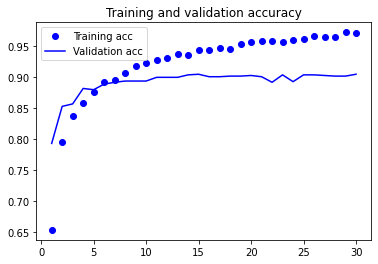

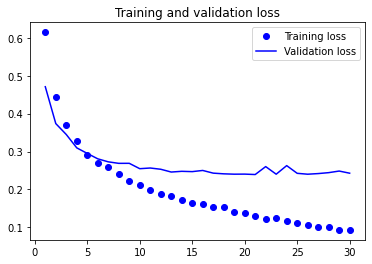

In [10]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

약 90%의 검증 정확도에 도달했습니다. 하지만 이 그래프는 많은 비율로 드롭아웃을 사용했음에도 훈련을 시작하면서 거의 바로 과대적합되고 있다는 것을 보여 줍니다. 작은 이미지 데이터셋에서는 과대적합을 막기 위해 필수적인 데이터 증식을 사용하지 않았기 때문입니다.

#### 데이터 증식을 사용한 특성 추출

#### 코드 5-20 합성곱 기반 층 위에 완전 연결 분류기 추가하기

In [6]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


모델을 컴파일하고 훈련하기 전에 합성곱 기반 층을 동결하는 것이 아주 중요합니다. 하나 이상의 층을 동결(freezing)한다는 것은 훈련하는 동안 가중치가 업데이트되지 않도록 막는다는 뜻입니다. 이렇게 하지 않으면 합성곱 기반 층에 의해 사전에 학습된 표현이 훈련하는 동안 수정될 것입니다. 맨 위의 Dense 층은 랜덤하게 초기화되었기 때문에 매우 큰 가중치 업데이트 값이 네트워크에 전파될 것입니다. 이는 사전에 학습된 표현을 크게 훼손하게 됩니다.

케라스에서는 trainable 속성을 False로 설정하여 네트워크를 동결할 수 있습니다.

In [7]:
print('conv_base를 동결하기 전 훈련되는 가중치의 수:', len(model.trainable_weights))
conv_base.trainable = False
print('conv_base를 동결한 후 훈련되는 가중치의 수:', len(model.trainable_weights))

conv_base를 동결하기 전 훈련되는 가중치의 수: 30
conv_base를 동결한 후 훈련되는 가중치의 수: 4


이렇게 설정하면 추가한 2개의 Dense 층 가중치만 훈련될 것입니다. 층마다 2개씩(가중치 행렬과 편향 벡터) 총 4개의 텐서가 훈련됩니다. 변경 사항을 적용하려면 먼저 모델을 컴파일해야 합니다. 컴파일 단계 후에 trainable 속성을 변경하면 반드시 모델을 다시 컴파일해야 합니다.

#### 5-21 동결된 합성곱 기반 층과 함께 모델을 엔드-투-엔드로 훈련하기

In [8]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

model.compile(loss='binary_crossentropy',
             optimizer=optimizers.RMSprop(lr=2e-5),
             metrics=['acc'])

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50,
    verbose=2)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
 - 17s - loss: 0.5580 - acc: 0.7295 - val_loss: 0.4223 - val_acc: 0.8210
Epoch 2/30
 - 15s - loss: 0.4158 - acc: 0.8295 - val_loss: 0.3377 - val_acc: 0.8790
Epoch 3/30
 - 16s - loss: 0.3498 - acc: 0.8610 - val_loss: 0.3008 - val_acc: 0.8870
Epoch 4/30
 - 15s - loss: 0.3237 - acc: 0.8665 - val_loss: 0.2863 - val_acc: 0.8840
Epoch 5/30
 - 15s - loss: 0.3085 - acc: 0.8700 - val_loss: 0.2680 - val_acc: 0.9020
Epoch 6/30
 - 15s - loss: 0.2870 - acc: 0.8840 - val_loss: 0.2601 - val_acc: 0.9040
Epoch 7/30
 - 15s - loss: 0.2790 - acc: 0.8740 - val_loss: 0.2561 - val_acc: 0.8980
Epoch 8/30
 - 16s - loss: 0.2707 - acc: 0.8915 - val_loss: 0.2471 - val_acc: 0.8990
Epoch 9/30
 - 23s - loss: 0.2583 - acc: 0.8965 - val_loss: 0.2427 - val_acc: 0.9060
Epoch 10/30
 - 16s - loss: 0.2568 - acc: 0.8975 - val_loss: 0.2401 - val_acc: 0.9080
Epoch 11/30
 - 16s - loss: 0.2520 - acc: 0.8990 - val_loss: 0.2411 - val_ac

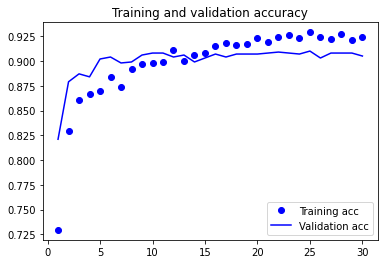

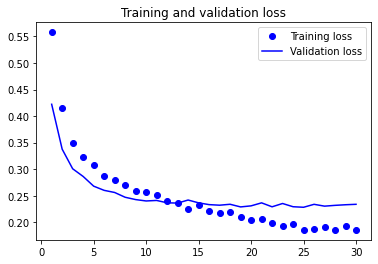

In [10]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

검증 정확도가 이전과 비슷하지만 처음부터 훈련시킨 소규모 컨브넷보다 과대적합이 줄었습니다.

### 5.3.2 미세 조정
미세 조정은 특성 추출에 사용했던 동결 모델의 상위 층 몇 개를 동결에서 해제하고 모델에 새로 추가한 층(여기서는 완전 연결 분류기)과 함께 훈련하는 것입니다.

네트워크를 미세 조정하는 단계는 다음과 같습늬다.
1. 사전에 훈련된 기반 네트워크 위에 새로운 네트워크를 추가합니다.
2. 기반 네트워크를 동결합니다.
3. 새로 추가한 네트워크를 훈련합니다.
4. 기반 네트워크에서 일부 층의 동결을 해제합니다.
5. 동결을 해제한 층과 새로 추가한 층을 함께 훈련합니다.

처음 세 단계는 특성 추출을 할 때 이미 완료했습니다. 네 번째 단계를 진행해 보죠. conv_base의 동결을 해제하고 개별 층을 동결하겠습니다.

기억을 되살리기 위해 합성곱 기반 층의 구조를 다시 확인해 보겠습니다.

In [11]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

마지막 3개의 합성곱 층을 미세 조정하겠습니다. 즉 block4_pool까지 모든 층은 동결되고 block5_conv1, block5_conv2, block5_con3 층은 학습 대상이 됩니다.

왜 더 많은 층을 미세 조정하지 않을까요? 왜 전체 합성곱 기반 층을 미세 조정하지 않을까요? 그렇게 할 수도 있지만 다음 사항을 고려해야 합니다.
- 합성곱 기반 층에 있는 하위 층들은 좀 더 일반적이고 재사용 가능한 특성들을 인코딩합니다. 반면에 상위 층은 좀 더 특화된 특성을 인코딩합니다. 새로운 문제에 재활용하도록 수정이 필요한 것은 구체적인 특성이므로 이들을 미세 조정하는 것이 유리합니다. 하위 층으로 갈수록 미세 조정에 대한 효과가 감소합니다.
- 훈련해야 할 파라미터가 많을수록 과대적합의 위험이 커집니다. 합성곱 기반 층은 1500만 개의 파라미터를 가지고 있습니다. 작은 데이터셋으로 전부 훈련하려고 하면 매우 위험합니다.

그러므로 이런 상황에서는 합성곱 기반 층에서 최상위 2~3개의 층만 미세 조정하는 것이 좋습니다.
#### 코드 5-22 특정 층까지 모든 층 동결하기

In [12]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

이제 네트워크의 미세 조정을 시작하겠습니다. 학습률을 낮춘 RMSProp 옵티마이저를 사용합니다. 학습률을 낮추는 이유는 미세 조정하는 3개의 층에서 학습된 표현을 조금씩 수정하기 위해서입니다. 변경량이 너무 크면 학습된 표현에 나쁜 영향을 끼칠 수 있습니다.

#### 5-23 모델 미세 조정하기

In [13]:
model.compile(loss='binary_crossentropy',
             optimizer=optimizers.RMSprop(lr=1e-5),
             metrics=['acc'])

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/100
100/100 [==============================] - 18s 179ms/step - loss: 0.1965 - acc: 0.9150 - val_loss: 0.2052 - val_acc: 0.9160
Epoch 2/100
100/100 [==============================] - 18s 176ms/step - loss: 0.1587 - acc: 0.9360 - val_loss: 0.2142 - val_acc: 0.9210
Epoch 3/100
100/100 [==============================] - 18s 177ms/step - loss: 0.1383 - acc: 0.9450 - val_loss: 0.2127 - val_acc: 0.9240
Epoch 4/100
100/100 [==============================] - 18s 177ms/step - loss: 0.1294 - acc: 0.9535 - val_loss: 0.2065 - val_acc: 0.9270
Epoch 5/100
100/100 [==============================] - 18s 176ms/step - loss: 0.1164 - acc: 0.9575 - val_loss: 0.2085 - val_acc: 0.9230
Epoch 6/100
100/100 [==============================] - 18s 176ms/step - loss: 0.0881 - acc: 0.9710 - val_loss: 0.2504 - val_acc: 0.9140
Epoch 7/100
100/100 [==============================] - 18s 176ms/step - loss: 0.0875 - acc: 0.9665 - val_loss: 0.2176 - val_acc: 0.9320
Epoch 8/100
100/100 [===========================

Epoch 61/100
100/100 [==============================] - 18s 177ms/step - loss: 0.0062 - acc: 0.9985 - val_loss: 0.3665 - val_acc: 0.9260
Epoch 62/100
100/100 [==============================] - 18s 178ms/step - loss: 0.0076 - acc: 0.9985 - val_loss: 0.3272 - val_acc: 0.9270
Epoch 63/100
100/100 [==============================] - 18s 177ms/step - loss: 0.0027 - acc: 0.9995 - val_loss: 0.3474 - val_acc: 0.9310
Epoch 64/100
100/100 [==============================] - 18s 177ms/step - loss: 0.0017 - acc: 0.9990 - val_loss: 0.3291 - val_acc: 0.9290
Epoch 65/100
100/100 [==============================] - 18s 177ms/step - loss: 0.0042 - acc: 0.9990 - val_loss: 0.3190 - val_acc: 0.9350
Epoch 66/100
100/100 [==============================] - 18s 177ms/step - loss: 0.0077 - acc: 0.9975 - val_loss: 0.3431 - val_acc: 0.9290
Epoch 67/100
100/100 [==============================] - 18s 178ms/step - loss: 0.0023 - acc: 0.9995 - val_loss: 0.3542 - val_acc: 0.9340
Epoch 68/100
100/100 [===================

In [14]:
#필요한 모듈을 import 합니다.
from numba import cuda

#이후 초기화 작업을 진행해줍니다.
device = cuda.get_current_device()
device.reset()

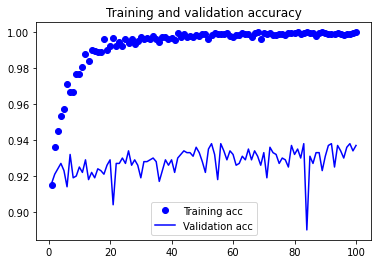

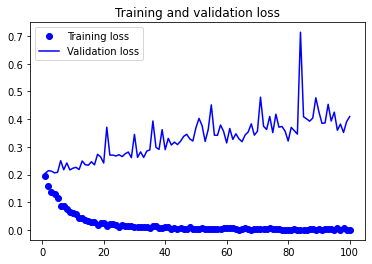

In [15]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#### 코드 5-24 부드러운 그래프 그리기

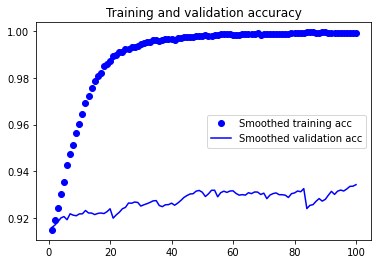

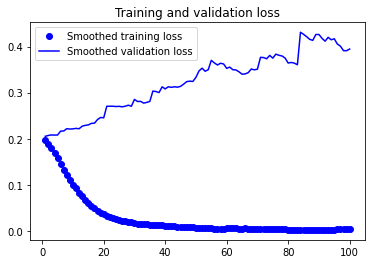

In [16]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

plt.plot(epochs, smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs, smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs, smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

정확도가 대략 1% 향상 되었습니다.

손실 곡선은 실제 어떤 향상을 얻지 못했습니다(사실 악화되었습니다). 손실이 감소되지 않았는데 어떻게 정확도가 안정되거나 향상될 수 있을까요? 답은 간단합니다. 그래프는 개별적인 손실 값의 평균을 그린 것입니다. 하지만 정확도에 영향을 미치는 것은 손실 값의 분포이지 평균이 아닙니다. 정확도는 모델이 예측한 클래스 확률이 어떤 임계 값을 넘었는지에 대한 결과이기 때문입니다. 모델이 더 향상되더라도 평균 손실에 반영되지 않을 수 있습니다.

In [6]:
from keras.preprocessing.image import ImageDataGenerator

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.


NameError: name 'model' is not defined

### 5.3.3 정리
- 컨브넷은 컴퓨터 비전 작업에 가장 뛰어난 머신 러닝 모델입니다.
- 작은 데이터셋에서는 과대적합이 큰 문제입니다. 데이터 증식은 이미지 데이터를 다룰 때 과대적합을 막을 수 있는 강력한 방법입니다.
- 특성 추출 방식으로 새로운 데이터셋에 기존 컨브넷을 쉽게 재사용할 수 있습니다.
- 특성 추출을 보완하기 위해 미세 조정을 사용할 수 있습니다.

In [ ]:
#필요한 모듈을 import 합니다.
from numba import cuda

#이후 초기화 작업을 진행해줍니다.
device = cuda.get_current_device()
device.reset()